In [1]:
from rich import print
from indra_db.client import get_curations
from collections import defaultdict
import pandas as pd
from collections import Counter
from tabulate import tabulate
from IPython.display import HTML
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
curations = get_curations()

In [3]:
dd: defaultdict[int, defaultdict[bool, dict[int, any]]] = defaultdict(lambda: defaultdict(dict))
for curation in curations:
    positive = curation["tag"] == "correct"
    dd[curation["pa_hash"]][positive][curation["id"]] = curation
dd = {k: dict(v) for k,v in dd.items()}

In [4]:
df = pd.DataFrame(
    [
        (
            k, 
            len(v.get(True, [])),
            len(v.get(False, [])),
        )
        for k, v in dd.items()
    ],
    columns=["stmt_hash", "correct", "incorrect"],
)
df

,stmt_hash,correct,incorrect
0,-3.133747e+16,0,1
1,1.061511e+16,0,1
2,-2.840638e+16,0,1
3,3.314674e+16,1,0
4,-1.312914e+16,0,2
...,...,...,...
6040,-3.224880e+16,0,1
6041,2.708855e+16,0,1
6042,-9.160669e+15,1,0
6043,1.010432e+16,1,7


In [5]:
remapping = {
    "patrick.anton.greene@gmail.com": "patrick_greene@hms.harvard.edu",
    "sambunga094@gmail.com": "samuel_bunga@hms.harvard.edu",
    "sambunga094@gmail.com@gmail.com": "samuel_bunga@hms.harvard.edu",
}
skip = {
    "minghanwu155@gmail.com", "tester"
}
renames = {
    "cthoyt": "Charlie Hoyt",
    "rphair": "Robert Phair",
    "depratt": "Dexter Pratt",
    "bachmanjohn": "John Bachman",
    "cgaray": "Christopher Garay",
    "vanauken": "Kim Van Auken",
}
curators = Counter(
    remapping.get(c["curator"], c["curator"]) 
    for c in curations 
    if c["curator"] not in skip
)

def _clean_email(s):
    s = s.split("@")[0]
    s = renames.get(s, s)
    return s.replace("_", " ").replace(".", " ").title()

count_df = pd.DataFrame(curators.most_common(), columns=["curator_email", "count"])
count_df["curator"] = count_df["curator_email"].map(_clean_email)
# count_df

In [6]:
positive = sorted((c["date"], c["tag"]) for c in curations if c["tag"] == "correct")
negative = sorted((c["date"], c["tag"]) for c in curations if c["tag"] != "correct")


time_df = pd.DataFrame(
    [
        *(("correct", tag, date, i) for i, (date, tag) in enumerate(positive)), 
        *(("incorrect", tag, date, i) for i, (date, tag) in enumerate(negative)),
    ],
    columns=["status", "tag", "date", "count"],
)
time_df

,status,tag,date,count
0,correct,correct,2018-11-14 05:49:04.832777,0
1,correct,correct,2018-11-14 07:48:43.475813,1
2,correct,correct,2018-11-14 07:49:13.238925,2
3,correct,correct,2018-11-14 07:49:37.893241,3
4,correct,correct,2018-11-14 07:56:41.955224,4
...,...,...,...,...
12713,incorrect,wrong_relation,2022-03-23 00:46:38.750450,6954
12714,incorrect,act_vs_amt,2022-03-23 00:48:32.508327,6955
12715,incorrect,act_vs_amt,2022-03-23 00:48:45.256581,6956
12716,incorrect,act_vs_amt,2022-03-23 00:49:11.581433,6957


In [7]:
error_type_df = time_df.groupby("tag").count()["date"].sort_values(ascending=False).to_frame().reset_index()
error_type_df.columns = ["tag", "count"]
error_type_df["tag"] = error_type_df["tag"].map(lambda s: s.replace("_", " ").title())
error_type_df = error_type_df[error_type_df["count"] > 1]
error_type_df

,tag,count
0,Correct,5759
1,No Relation,1711
2,Grounding,1630
3,Wrong Relation,896
4,Entity Boundaries,848
5,Polarity,666
6,Act Vs Amt,421
7,Other,266
8,Negative Result,234
9,Hypothesis,185


/var/folders/f8/snw3tlcs0y3bmnq5gqg26b5h0000gn/T/ipykernel_53861/1154768491.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  rax.set_xticklabels(rax.get_xticklabels(), rotation=30)


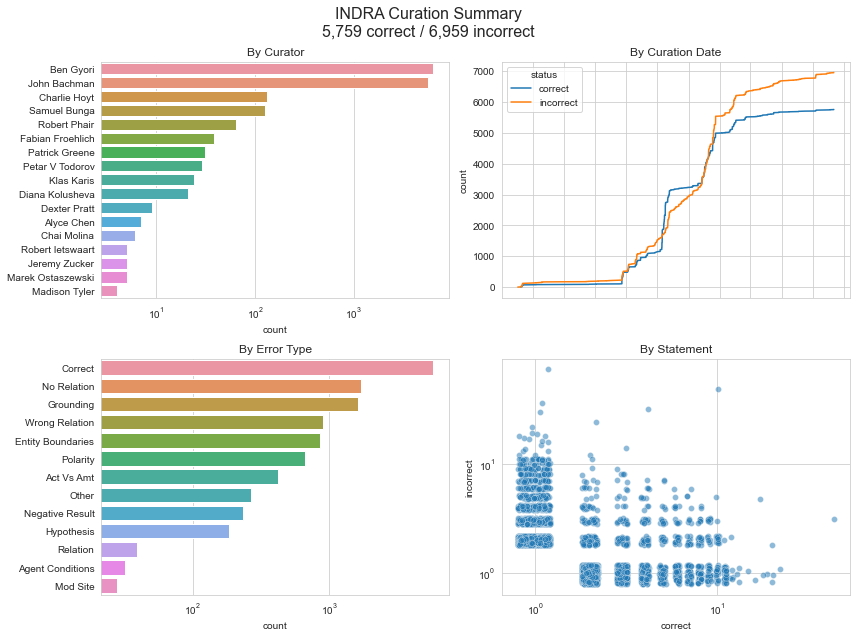

In [8]:
sns.set_style("whitegrid")

fig, ((lax, rax), (blax, brax)) = plt.subplots(2, 2, figsize=(12, 9))

sns.barplot(data=count_df[count_df["count"] > 2], y="curator", x="count", ax=lax)
lax.set_xscale("log")
lax.set_ylabel("")
lax.set_title("By Curator")


sns.lineplot(data=time_df, x="date", y="count", hue="status", ax=rax)
# FIXME
# rax.set_xticklabels(rax.get_xticklabels(), rotation=30)
rax.set_title("By Curation Date")
rax.set_xlabel("")

sns.barplot(data=error_type_df, x="count", y="tag", ax=blax)
blax.set_ylabel("")
blax.set_title("By Error Type")
blax.set_xscale("log")

sns.scatterplot(
    data=df, 
    x=1 + df["correct"] + np.random.uniform(-0.2, 0.2, size=df["correct"].size), 
    y=1 + df["incorrect"] + np.random.uniform(-0.2, 0.2, size=df["incorrect"].size), 
    alpha=0.5,
    ax=brax,
)
brax.set_xscale("log")
brax.set_yscale("log")
brax.set_title("By Statement")
      
total_correct = df.correct.sum()
total_incorrect = df.incorrect.sum()
plt.suptitle(f"INDRA Curation Summary\n{total_correct:,} correct / {total_incorrect:,} incorrect", size=16)

plt.tight_layout()
plt.savefig("/Users/cthoyt/Desktop/curation_summary.png", dpi=300)
plt.show()